# Aim:
To apply Wasserstein GAN with gradient penalty for generating synthetic images on the FashionMNIST dataset, addressing issues of GAN training stability and fidelity.

In [1]:
import os
os.environ["KERAS_BACKEND"]="tensorflow"
import keras
import tensorflow as tf
from keras import layers

In [2]:
IMG_SHAPE=(28,28,1)
BATCH_SIZE=512
noise_dim=128
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of examples: 60000
Shape of the images in the dataset: (28, 28)


In [3]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 512)           │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,305,409 (16.42 MB)

 Trainable params: 4,305,409 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │         294,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 1)           │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d (Cropping2D)              │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 910,660 (3.47 MB)

 Trainable params: 902,082 (3.44 MB)

 Non-trainable params: 8,578 (33.51 KB)

In [6]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]


        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
import matplotlib.pyplot as plt

generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - d_loss: -7.1850 - g_loss: -13.9774Epoch 1/20 - Generator Loss: -16.509754180908203, Discriminator Loss: -6.772209167480469


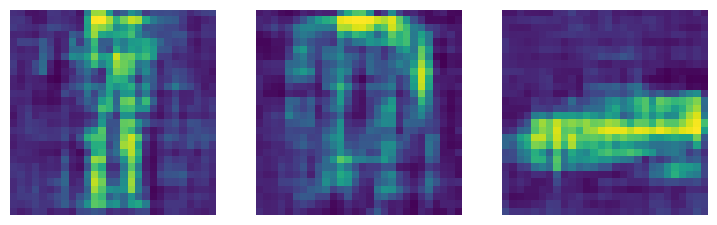

Subjective Test: How do the generated images look after epoch 1? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 127s 779ms/step - d_loss: -7.1816 - g_loss: -13.9987
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -6.1527 - g_loss: -14.8938Epoch 2/20 - Generator Loss: -13.868769645690918, Discriminator Loss: -5.9104132652282715


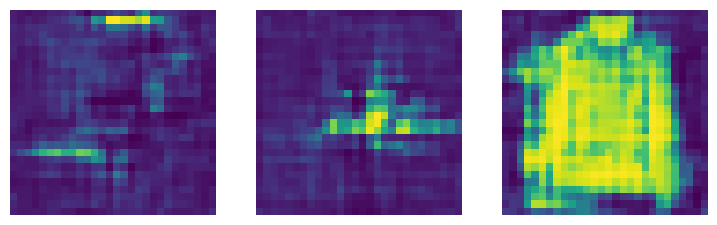

Subjective Test: How do the generated images look after epoch 2? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 45s 384ms/step - d_loss: -6.1507 - g_loss: -14.8852
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -5.5584 - g_loss: -13.7035Epoch 3/20 - Generator Loss: -15.850227355957031, Discriminator Loss: -5.278107166290283


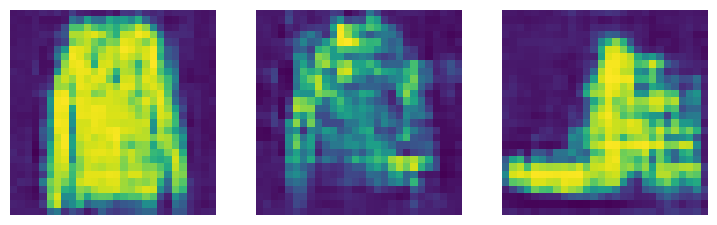

Subjective Test: How do the generated images look after epoch 3? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 60s 507ms/step - d_loss: -5.5560 - g_loss: -13.7216
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -5.0846 - g_loss: -12.7055Epoch 4/20 - Generator Loss: -12.504240036010742, Discriminator Loss: -4.860869407653809


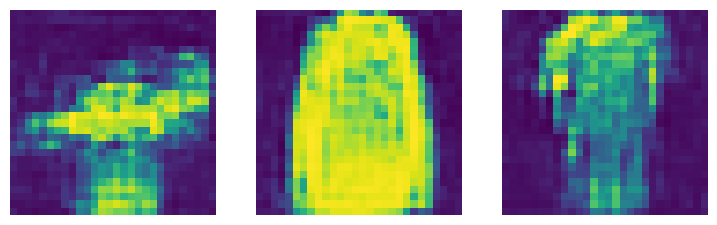

Subjective Test: How do the generated images look after epoch 4? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 44s 373ms/step - d_loss: -5.0827 - g_loss: -12.7039
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -4.7277 - g_loss: -11.4488Epoch 5/20 - Generator Loss: -10.190999031066895, Discriminator Loss: -5.101190090179443


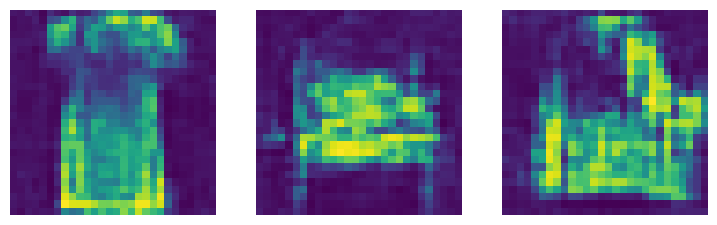

Subjective Test: How do the generated images look after epoch 5? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 351ms/step - d_loss: -4.7309 - g_loss: -11.4382
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - d_loss: -4.3951 - g_loss: -10.1114Epoch 6/20 - Generator Loss: -12.276458740234375, Discriminator Loss: -4.051644325256348


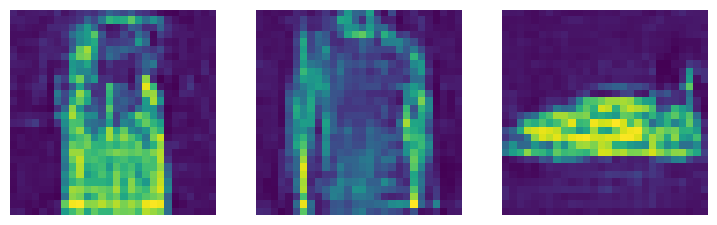

Subjective Test: How do the generated images look after epoch 6? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 39s 333ms/step - d_loss: -4.3922 - g_loss: -10.1296
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -4.1318 - g_loss: -10.3299Epoch 7/20 - Generator Loss: -8.425010681152344, Discriminator Loss: -4.420044422149658


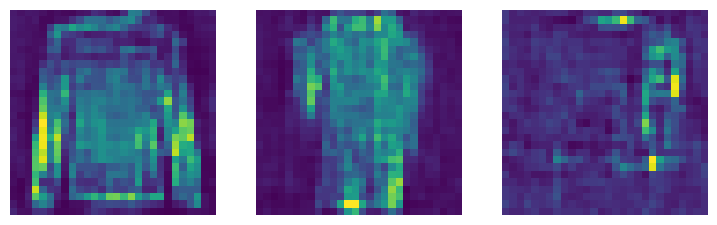

Subjective Test: How do the generated images look after epoch 7? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 38s 325ms/step - d_loss: -4.1343 - g_loss: -10.3139
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -3.9055 - g_loss: -10.2599Epoch 8/20 - Generator Loss: -10.000040054321289, Discriminator Loss: -4.487153053283691


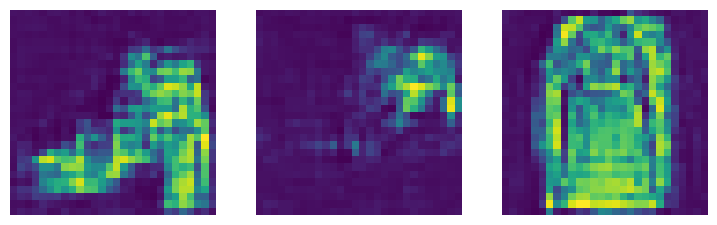

Subjective Test: How do the generated images look after epoch 8? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - d_loss: -3.9104 - g_loss: -10.2577
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - d_loss: -3.7418 - g_loss: -10.1063Epoch 9/20 - Generator Loss: -14.415084838867188, Discriminator Loss: -3.9827818870544434


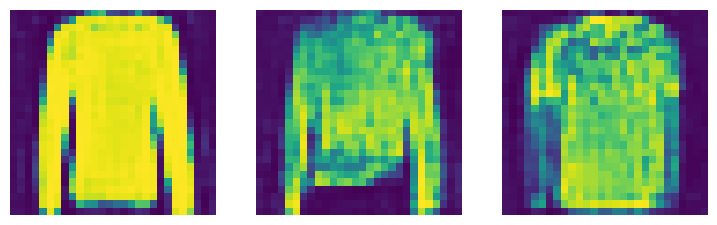

Subjective Test: How do the generated images look after epoch 9? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 47s 396ms/step - d_loss: -3.7438 - g_loss: -10.1425
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -3.5668 - g_loss: -9.3412Epoch 10/20 - Generator Loss: -9.465316772460938, Discriminator Loss: -3.5587496757507324


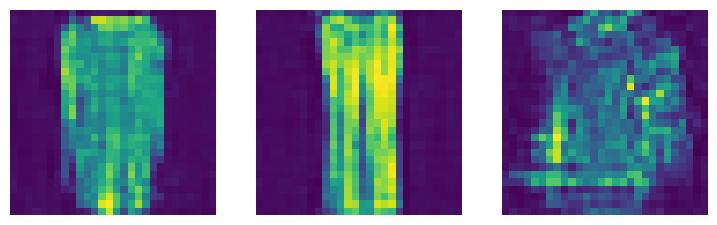

Subjective Test: How do the generated images look after epoch 10? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 351ms/step - d_loss: -3.5667 - g_loss: -9.3423
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -3.4076 - g_loss: -8.8648Epoch 11/20 - Generator Loss: -8.946455001831055, Discriminator Loss: -3.236297845840454


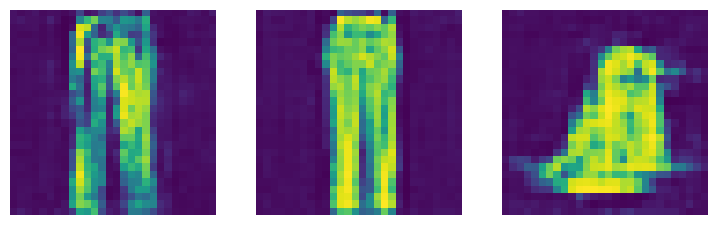

Subjective Test: How do the generated images look after epoch 11? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 42s 356ms/step - d_loss: -3.4062 - g_loss: -8.8655
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -3.3180 - g_loss: -8.0064Epoch 12/20 - Generator Loss: -10.273048400878906, Discriminator Loss: -3.427910804748535


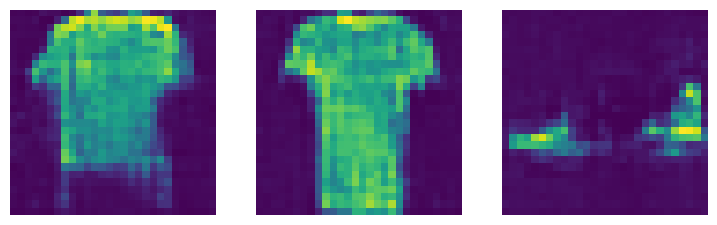

Subjective Test: How do the generated images look after epoch 12? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 38s 325ms/step - d_loss: -3.3189 - g_loss: -8.0255
Epoch 13/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -3.1643 - g_loss: -7.6316Epoch 13/20 - Generator Loss: -10.913414001464844, Discriminator Loss: -3.2102787494659424


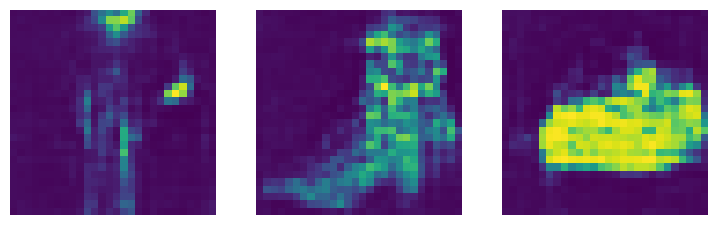

Subjective Test: How do the generated images look after epoch 13? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 337ms/step - d_loss: -3.1647 - g_loss: -7.6592
Epoch 14/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - d_loss: -3.0883 - g_loss: -7.4351Epoch 14/20 - Generator Loss: -8.09778118133545, Discriminator Loss: -3.8407187461853027


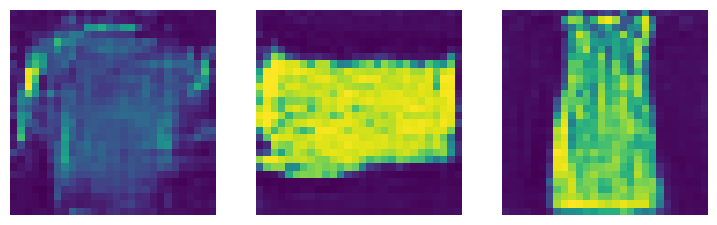

Subjective Test: How do the generated images look after epoch 14? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - d_loss: -3.0946 - g_loss: -7.4406
Epoch 15/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -2.9842 - g_loss: -6.9999Epoch 15/20 - Generator Loss: -6.77316427230835, Discriminator Loss: -3.2524068355560303


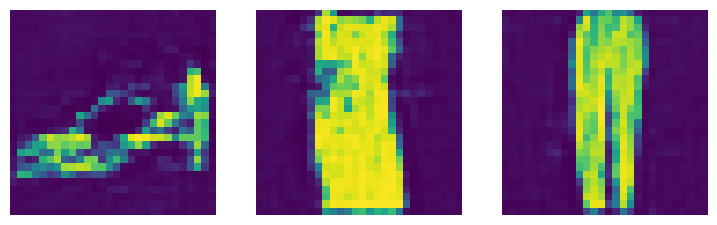

Subjective Test: How do the generated images look after epoch 15? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 59s 498ms/step - d_loss: -2.9864 - g_loss: -6.9980
Epoch 16/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -2.8683 - g_loss: -6.7762Epoch 16/20 - Generator Loss: -7.0870680809021, Discriminator Loss: -3.178323745727539


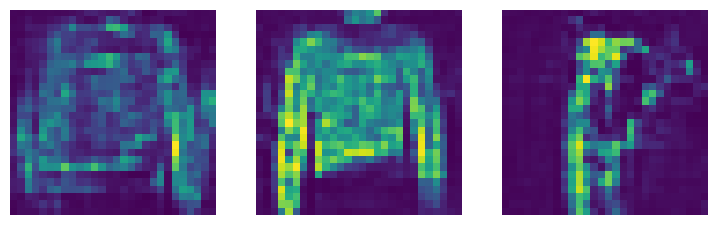

Subjective Test: How do the generated images look after epoch 16? (Good/Bad)  good\


User Feedback: good\
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 340ms/step - d_loss: -2.8709 - g_loss: -6.7788
Epoch 17/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - d_loss: -2.8347 - g_loss: -6.4632Epoch 17/20 - Generator Loss: -5.644775390625, Discriminator Loss: -3.0633814334869385


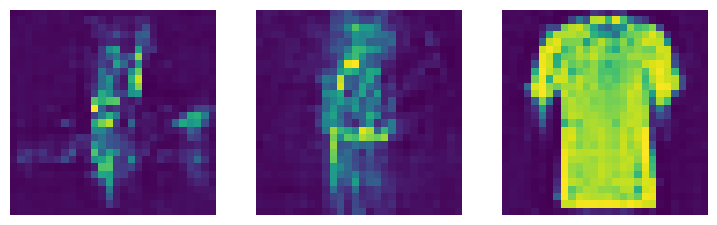

Subjective Test: How do the generated images look after epoch 17? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 38s 324ms/step - d_loss: -2.8366 - g_loss: -6.4563
Epoch 18/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -2.7479 - g_loss: -6.3395Epoch 18/20 - Generator Loss: -6.1005988121032715, Discriminator Loss: -3.2000861167907715


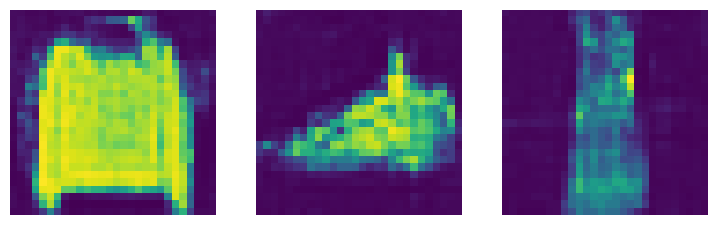

Subjective Test: How do the generated images look after epoch 18? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 42s 354ms/step - d_loss: -2.7517 - g_loss: -6.3375
Epoch 19/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - d_loss: -2.6825 - g_loss: -5.6073Epoch 19/20 - Generator Loss: -7.6266913414001465, Discriminator Loss: -3.0445079803466797


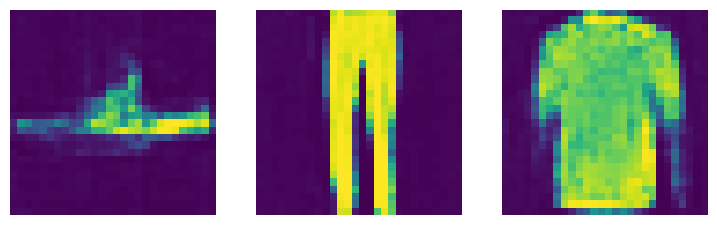

Subjective Test: How do the generated images look after epoch 19? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 43s 361ms/step - d_loss: -2.6856 - g_loss: -5.6242
Epoch 20/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - d_loss: -2.6194 - g_loss: -5.1228Epoch 20/20 - Generator Loss: -5.061931610107422, Discriminator Loss: -2.6440727710723877


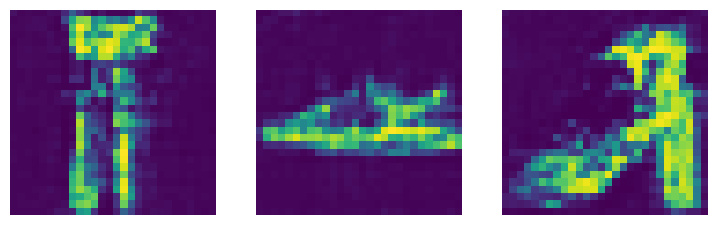

Subjective Test: How do the generated images look after epoch 20? (Good/Bad)  good


User Feedback: good
118/118 ━━━━━━━━━━━━━━━━━━━━ 59s 505ms/step - d_loss: -2.6196 - g_loss: -5.1222


In [9]:
epochs = 20

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        gen_loss = logs.get('g_loss', 0)
        disc_loss = logs.get('d_loss', 0)
        print(f"Epoch {epoch+1}/{epochs} - Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")

        if gen_loss < 0 or disc_loss < 0:
            print("Warning: Loss values are negative, checking model stability.")

        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        fig, axes = plt.subplots(1, self.num_img, figsize=(self.num_img * 3, 3))
        for i in range(self.num_img):
            img = generated_images[i].numpy().astype("uint8")
            axes[i].imshow(img)
            axes[i].axis("off")
        plt.show()

        subjective_test = input(f"Subjective Test: How do the generated images look after epoch {epoch+1}? (Good/Bad) ")
        print(f"User Feedback: {subjective_test}")

callbacks = GANMonitor(num_img=3, latent_dim=noise_dim)

wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[callbacks])


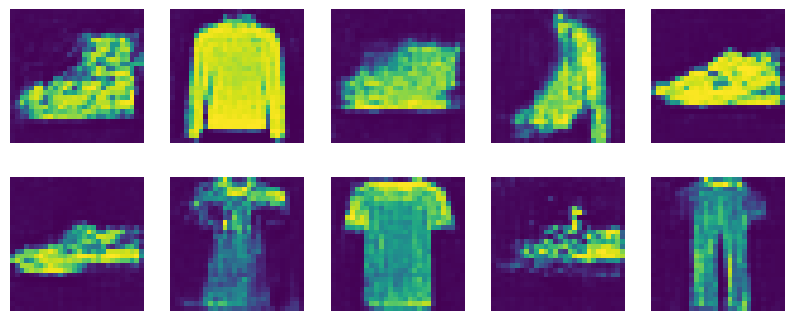

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf

num_images = 10  
random_latent_vectors = tf.random.normal(shape=(num_images, noise_dim))
generated_images = g_model(random_latent_vectors)
generated_images = (generated_images * 127.5) + 127.5

fig, axes = plt.subplots(2, num_images // 2, figsize=(num_images, 4))
for i, ax in enumerate(axes.flat):
    img = generated_images[i].numpy().astype("uint8")
    ax.imshow(img)
    ax.axis("off")
plt.show()
